In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_pickle('norm_all_data.pickle')
df = df.dropna()
df, test = train_test_split(df, test_size=10000, random_state=42)
train, valid = train_test_split(df, test_size=5000, random_state=42)

print( len(train), len(valid), len(test))

161783 5000 10000


In [3]:
X_audio_train = np.array(list( train['audio_data'] ))
y_train = np.array(train['song_hotttnesss']).reshape(-1, 1)
X_feat_train = np.array(train.drop(columns = ['audio_data', 'song_hotttnesss']))

X_audio_valid = np.array(list( valid['audio_data'] ))
y_valid = np.array(valid['song_hotttnesss']).reshape(-1, 1)
X_feat_valid = np.array(valid.drop(columns = ['audio_data', 'song_hotttnesss']))

X_audio_test = np.array(list( test['audio_data'] ))
y_test = np.array(test['song_hotttnesss']).reshape(-1, 1)
X_feat_test = np.array(test.drop(columns = ['audio_data', 'song_hotttnesss']))

print( X_audio_train.shape, X_feat_train.shape, y_train.shape )
print( X_audio_valid.shape, X_feat_valid.shape, y_valid.shape )
print( X_audio_test.shape, X_feat_test.shape, y_test.shape )

(161783, 120, 28) (161783, 28) (161783, 1)
(5000, 120, 28) (5000, 28) (5000, 1)
(10000, 120, 28) (10000, 28) (10000, 1)


In [4]:
med = np.median(y_train)

def accuracy(pred, labels):
    return ( (pred > med) == (labels > med) ).astype(np.float64).mean()*100

In [53]:
batch_size = 64
time_per_cell = 10
skip_time = 5
time = 120
features_at_time = 28
audio_end_feat = 16
num_feat = X_feat_train.shape[-1]

num_nodes = [
    [time_per_cell*features_at_time, 32],
    [32, 32],
    [32, 32],
    [32, 32]
]

dense_layers = [
    #[audio_end_feat, 1]
    [audio_end_feat + num_feat, 128],
    [128, 64],
    [64, 32],
    [32, 1]
]

dropout = [1.0, 1.0, 1.0, 1.0]

num_unrollings = (time - time_per_cell) // skip_time

graph = tf.Graph()
with graph.as_default():
  
  # Inputs
  X_tr_audio = tf.placeholder(tf.float32, shape=(batch_size, time, features_at_time))
  X_tr_feat = tf.placeholder(tf.float32, shape=(batch_size, num_feat))
  y_tr = tf.placeholder(tf.float32, shape=(batch_size, 1))
  X_te_audio = tf.constant(X_audio_test.astype(np.float32))
  X_te_feat = tf.constant(X_feat_test.astype(np.float32))
  X_val_audio = tf.constant(X_audio_valid.astype(np.float32))
  X_val_feat = tf.constant(X_feat_valid.astype(np.float32))
    
  tr_inputs = []
  for i in range(num_unrollings):
    tr_inputs.append(tf.reshape( X_tr_audio[:, skip_time*i:skip_time*i+time_per_cell], (batch_size, -1) ))
    
  val_inputs = []
  for i in range(num_unrollings):
    val_inputs.append(tf.reshape( X_val_audio[:, skip_time*i:skip_time*i+time_per_cell], (X_audio_valid.shape[0], -1) ))
    
  te_inputs = []
  for i in range(num_unrollings):
    te_inputs.append(tf.reshape( X_te_audio[:, skip_time*i:skip_time*i+time_per_cell], (X_audio_test.shape[0], -1) ))

  # Variables
  w = []
  b = []
  for i, s in enumerate(num_nodes):
    w.append(tf.Variable(tf.truncated_normal((s[0]+s[1], 4*s[1]), stddev=0.1), name='w'+str(i), trainable=True))
    b.append(tf.Variable(tf.zeros([4*s[1]]), name='b'+str(i), trainable=True))
    
  w_dense = tf.Variable(tf.truncated_normal((num_nodes[-1][-1], audio_end_feat), stddev=1.0), name='w_dense', trainable=True)
  b_dense = tf.Variable(tf.zeros(audio_end_feat), name='b_dense', trainable=True)
    
  #w_hat = tf.Variable(tf.truncated_normal((num_unrollings, 1), stddev=1.0))
  #b_hat = tf.Variable(tf.zeros(1))

  # Definition of the cell computation.
  # m = tf.matmul(tf.concat([i, o], axis=1), w) + b
  def lstm_cell(m, state):
    i, f, c, o = tf.split(m, num_or_size_splits=4, axis=1)
    input_gate = tf.sigmoid(i)
    forget_gate = tf.sigmoid(f)
    state = forget_gate * state + input_gate * tf.tanh(c)
    output_gate = tf.sigmoid(o)
    return output_gate * tf.tanh(state), state

  # Unrolling
  def unrolling(inputs, training=False):
    states = []
    outputs = []
    #ans = []
    for i in range(len(w)):
      states.append(tf.zeros([inputs[0].get_shape()[0], num_nodes[i][1]]))
      outputs.append(tf.zeros([inputs[0].get_shape()[0], num_nodes[i][1]]))
    for j in range(num_unrollings):
      for i in range(len(w)):
        if i==0: inp = inputs[j]
        else:
            if training:
                inp = tf.nn.dropout(outputs[i-1], dropout[i-1])
            else:
                inp = outputs[i-1]
        m = tf.nn.xw_plus_b(tf.concat((inp, outputs[i]), axis=1), w[i], b[i])
        outputs[i], states[i] = lstm_cell(m, states[i])
      #ans.append(
      #    tf.nn.relu(
      #        tf.nn.xw_plus_b(outputs[-1], w_dense, b_dense)))
    #return tf.transpose( tf.reshape(ans, [num_unrollings, inputs[0].get_shape()[0]]) )
    return tf.nn.tanh( tf.nn.xw_plus_b(outputs[-1], w_dense, b_dense) )

  tr_outputs = unrolling(tr_inputs, True) #tf.nn.xw_plus_b( unrolling(tr_inputs, True), w_hat, b_hat )
  tr_outputs2 = unrolling(tr_inputs) #tf.nn.xw_plus_b( unrolling(tr_inputs), w_hat, b_hat )
  val_outputs = unrolling(val_inputs) #tf.nn.xw_plus_b( unrolling(val_inputs), w_hat, b_hat )
  te_outputs = unrolling(te_inputs) #tf.nn.xw_plus_b( unrolling(te_inputs), w_hat, b_hat )

  w_d = []
  b_d = []
  for d in dense_layers:
    w_d.append(tf.Variable(tf.truncated_normal(d, stddev=0.1)))
    b_d.append(tf.Variable(tf.zeros(d[1])))

  def model(feat_data, audio_outputs):
    #hidden = audio_outputs
    #print(feat_data.get_shape(), audio_outputs.get_shape())
    hidden = tf.concat([feat_data, audio_outputs], axis=1)
    for i in range(len(dense_layers)):
        #print(hidden.get_shape(), w_d[i].get_shape())
        hidden = tf.nn.xw_plus_b(hidden, w_d[i], b_d[i])
        if i < len(dense_layers)-1:
            hidden = tf.nn.tanh(hidden)
    return hidden
    
  logits = model(X_tr_feat, tr_outputs)
  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tr, logits=logits))
  #optimizer = tf.train.AdagradOptimizer(1e-1).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)

  # Predictions.
  tr_pred = tf.nn.sigmoid(model(X_tr_feat, tr_outputs2))
  val_pred = tf.nn.sigmoid(model(X_val_feat, val_outputs))
  te_pred = tf.nn.sigmoid(model(X_te_feat, te_outputs))

Initialized
INFO:tensorflow:Restoring parameters from ./RNN
Avg loss at step 0: 0.693884
Avg accuracy: 59.4%
Validation accuracy: 49.9%
Avg loss at step 100: 0.621469
Avg accuracy: 67.2%
Validation accuracy: 70.8%
Avg loss at step 200: 0.611295
Avg accuracy: 70.4%
Validation accuracy: 71.1%
Avg loss at step 300: 0.607380
Avg accuracy: 72.0%
Validation accuracy: 71.4%
Avg loss at step 400: 0.611006
Avg accuracy: 72.0%
Validation accuracy: 73.1%
Avg loss at step 500: 0.612499
Avg accuracy: 72.2%
Validation accuracy: 72.8%
Avg loss at step 600: 0.607557
Avg accuracy: 71.9%
Validation accuracy: 72.6%
Avg loss at step 700: 0.605606
Avg accuracy: 73.1%
Validation accuracy: 73.2%
Avg loss at step 800: 0.607834
Avg accuracy: 73.0%
Validation accuracy: 73.0%
Avg loss at step 900: 0.603935
Avg accuracy: 73.5%
Validation accuracy: 72.7%
Avg loss at step 1000: 0.606603
Avg accuracy: 73.3%
Validation accuracy: 73.5%
Avg loss at step 1100: 0.606952
Avg accuracy: 73.3%
Validation accuracy: 73.2%
Avg 

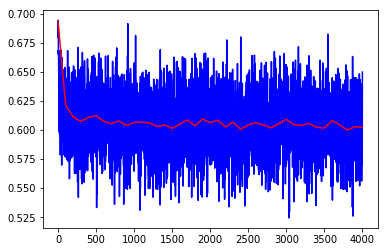

In [54]:
num_steps = 4001

with tf.Session(graph=graph) as session:
  losses=[]
  avg=[]
  preds = 0
  tf.global_variables_initializer().run()
  print('Initialized')
  load_var = []
  for i in range(len(num_nodes)):
    load_var.append(w[i])
    load_var.append(b[i])
  #load_var.append(w_dense)
  #load_var.append(b_dense)
  new_saver = tf.train.Saver(load_var)
  new_saver.restore(session, tf.train.latest_checkpoint('./'))
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_audio_data = X_audio_train[offset:(offset + batch_size), :, :]
    batch_feat_data = X_feat_train[offset:(offset + batch_size), :]
    batch_labels = y_train[offset:(offset + batch_size)]
    feed_dict = {X_tr_audio : batch_audio_data, X_tr_feat : batch_feat_data, y_tr : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tr_pred], feed_dict=feed_dict)
    losses.append(l)
    preds += accuracy(predictions, batch_labels)
    if (step % 100 == 0):
      #print(predictions)
      if step==0: preds *= 100
      avg.append(sum(losses[-100:])/len(losses[-100:]))
      print('Avg loss at step %d: %f' % (step, avg[-1]))
      print('Avg accuracy: %.1f%%' % (preds / 100))
      preds = 0
      print('Validation accuracy: %.1f%%' % accuracy(val_pred.eval(), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(te_pred.eval(), y_test))
  plt.plot(range(num_steps), losses, 'b', np.array(range(len(avg)))*100, avg, 'r')
  plt.show()